## Layer Normalisation

In [17]:
import torch
import torch.nn as nn

torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [18]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [19]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)

print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [20]:
class LayerNorm(nn.Module):

    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift #mx + c. scale and shift are the learnable parameters
    


In [21]:
ln = LayerNorm(5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True)

print("LayerNorm outputs:\n", out_ln)
print("Mean:\n", mean)
print("Variance:\n", var)

LayerNorm outputs:
 tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.2499],
        [1.2500]], grad_fn=<VarBackward0>)


## GeLU Activation Function

gelu activation function mathematical formula:

$$ f(x) = 0.5x(1 + tanh(\sqrt{2/\pi}(x + 0.044715x^3))) $$

In [22]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
                    torch.sqrt(torch.tensor(2.0) / torch.pi) * 
                    (x + 0.44715 * torch.pow(x, 3)
                )
            )
        )

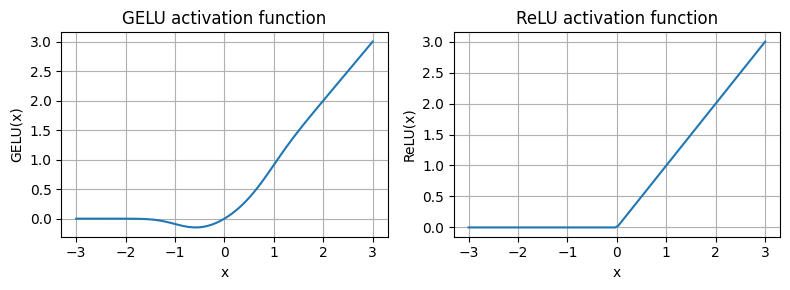

In [23]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
 
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

The smoothness of GELU can lead to better optimization properties during training, as it allows for more nuanced adjustments to the model's parameters. In contrast, ReLU has a sharp corner at zero, which can sometimes make optimization harder, especially in networks that are very deep or have complex architectures. Moreover, unlike RELU, which outputs zero for any negative input, GELU allows for a small, non-zero output for negative values. This characteristic means that during the training process, neurons that receive negative input can still contribute to the learning process, albeit to a lesser extent than positive inputs

In [28]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)
    

In [29]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 1024,      # Context length
    "emb_dim": 768,       # Embedding dimension
    "n_heads": 12,        # Number of attention heads
    "n_layers": 12,       # Number of layers
    "drop_rate": 0.1,     # Dropout rate
    "qkv_bias": False     # Query-Key-Value bias
}

In [30]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2, 3, 768)
out = ffn(x)
out

tensor([[[-0.3717, -0.2019,  0.1961,  ..., -0.2702,  0.0683,  0.2355],
         [ 0.0063,  0.0706,  0.4140,  ...,  0.1767, -0.0537, -0.1279],
         [ 0.1751, -0.1655, -0.1007,  ..., -0.3212,  0.2659, -0.1650]],

        [[ 0.3045,  0.0826,  0.1324,  ..., -0.2859, -0.0285, -0.2395],
         [-0.1005,  0.2507,  0.0544,  ..., -0.2401,  0.0284, -0.2866],
         [ 0.2492, -0.0038, -0.3012,  ..., -0.1008, -0.0374,  0.0472]]],
       grad_fn=<ViewBackward0>)